In [1]:
import numpy as np
import math as math
import matplotlib.pyplot as plt

# Fisher's Linear Discriminant as a Test Statistic

In this example, we will construct a linear discriminant following the Fisher Discriminant formulation.  This algorithm works very well for linearly separable data, as you will see.  However, it will do less well for complex data that is not easily separable by a linear function (in D dimensions).

We'll make some data and then work through the process forming the Fisher's Discriminant, which will give us a one-dimensional test statistic.

The point of this exercise is to take D dimensional data over K classes and transform to a one dimensional space that optimally separates the classes.  For linearly separable data, this would allow us to form a hypothesis test that gives us the highest power for a given hypothesis test significance level.

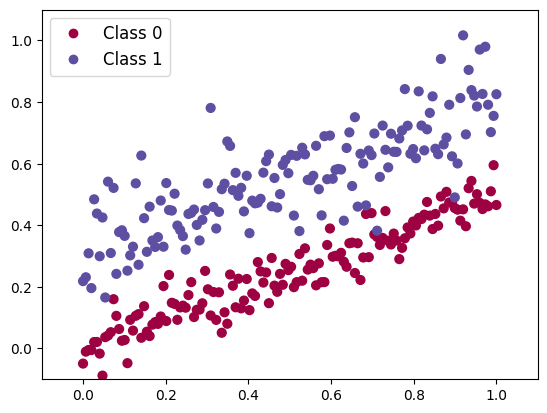

In [2]:
# Make some data!!
np.random.seed(111)

N = 150 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes

X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')

easy = True  #set this to 1/True to have an easier data sample to train on
slopeDiff = 0.0  # parameter for easy data
offsetDiff = 0.3 # parameter for easy data

min = -1
max = 1
if easy:
    min = -0.1
    max = 1.1
    
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    xx = r*np.sin(t)
    yy = r*np.cos(t)
    if easy:
        xx = np.linspace(0,1,N)
        yy = (0.5+0.5*slopeDiff*(j+1))*xx + np.random.randn(N)*(0.05+j*0.05) + j*offsetDiff
    
    X[ix] = np.c_[xx,yy]
    y[ix] = j

clabel = ["Class 0", "Class 1","Class 2"]
fig = plt.figure()
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([min,max])
plt.ylim([min,max])
handles, labs = scatter.legend_elements() 
plt.legend(handles,clabel,fontsize="large")
plt.show()

### Recall the Fisher Discriminant formulation

We are hypothesizing that there exists a linear function that will map our variables to a space with maximal separation between classes: $t(\vec{x}) = \sum_{i=1}^k a_i x_i$, where the variable $k$ indexes the number of dimensions for our data.

Fisher's work suggests that the $\vec{a}$ can be found by maximizing $J(\vec{a}) = {(\tau_1 - \tau_0)^2 \over \Sigma^2_1 -\Sigma^2_0}$, where $\tau$ and $\Sigma^2$ are the mean and variances of the transformed classes.  And this quantity to be maximized can be expressed as $J(\vec{a}) = {\vec{a}^T B \vec{a} \over \vec{a}^T B \vec{a}}$ where $B$ and $W$ are so-called "scatter matrices" (assuming 2 classes k):

* Scatter in feature space: $S_k = \sum_{i=1}^n (\vec{x}^i_k - \vec{\mu}_k)(\vec{x}^i_k - \vec{\mu}_k)^T$
* Within-class scatter matrix: $W = \sum_k S_k$
* Between-class scatter matrix: $B = (\vec{\mu}_1 - \vec{\mu}_0)(\vec{\mu}_1 - \vec{\mu}_0)^T$

By setting the derivative of $J(\vec{a})$ to zero, we can find that the coefficients of the linear discriminant are: $\vec{a} \propto W^{-1} B$.  Thus, we will need to calculate $W$, $B$, and the eigenvectors and eigenvalues of $W^{-1} B$.

In [3]:
# First the vector of means in each dimension
np.set_printoptions(precision=4) # tell numpy to only give me 4 digits of precision

mean_vectors = []
for cl in range(0,K):
    mean_vectors.append(np.mean(X[y==cl],axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl]))

Mean Vector class 0: [0.5    0.2489]

Mean Vector class 1: [0.5    0.5547]



In [4]:
# Now calculate the scatter matrix within classes
# This is telling us something about the variance of each class in each dimension
S_W = np.zeros((K,K))
for cl,mv in zip(range(0,K), mean_vectors):
    class_sc_mat = np.zeros((K,K))                  # empty scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(K,1), mv.reshape(K,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[25.3356 12.3334]
 [12.3334  7.8253]]


In [5]:
# Now calculate the scatter matrix between classes
# This is telling us something about how well separated the means are, on average
overall_mean = np.mean(mean_vectors, axis=0)

S_B = np.zeros((K,K)) # empty scatter matrix for each class
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i,:].shape[0]
    mean_vec = mean_vec.reshape(K,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 2.8936  0.    ]
 [ 0.     16.919 ]]


In [6]:
# Finally, we can find the eigen values and eigen vectors of our
# discriminant transformation!
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(K,1)   
    print('\nEigenvector {}: \n{}'.format(i, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i, eig_vals[i].real))


Eigenvector 0: 
[[-0.9965]
 [-0.084 ]]
Eigenvalue 0: 1.10e-01

Eigenvector 1: 
[[ 0.4419]
 [-0.8971]]
Eigenvalue 1: 9.67e+00


### At this point, we have our coefficients!

We can choose one of the eigen vectors to decompose our data.  Effectively we are rotating in space along one eigenvector and then projecting the data into that 1-dimensional space.  

Given that the eigen value for the 2nd eigen vector is largest (by a lot!), we'll use that one.

What we're going to do is project the data values along the largest eigen vector.  We do this by our original assumption that we have a function $t(\vec{x}) = \sum_{i=1}^k a_i x_i$ that maps to an optimal space to separate our classes.

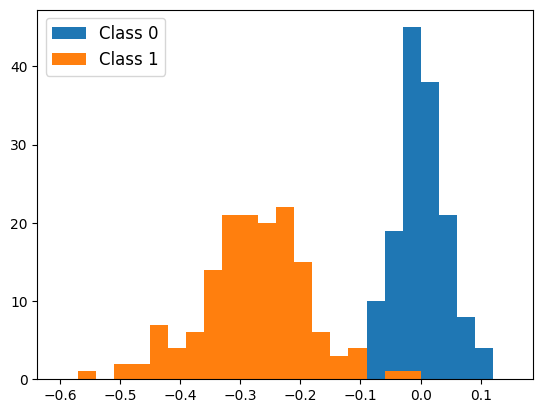

In [7]:
# Dot the data values into the eigen vectors to get the test statistic.
T = X.dot(eig_vecs[:,1])

# Plot it!
fig = plt.figure()
plt.hist(T[y==0],bins=25, range=(-0.6,0.15), label="Class 0")
plt.hist(T[y==1],bins=25, range=(-0.6,0.15), label="Class 1")
plt.legend(fontsize="large")
plt.show()

### Great, we have a nice space within which to separate our classes

The point of this exercise is to take D dimensional data over K classes and transform to a one dimensional space that optimally separates the classes.  For linearly separable data, this would allow us to form a hypothesis test that gives us the highest power for a given hypothesis test significance level.

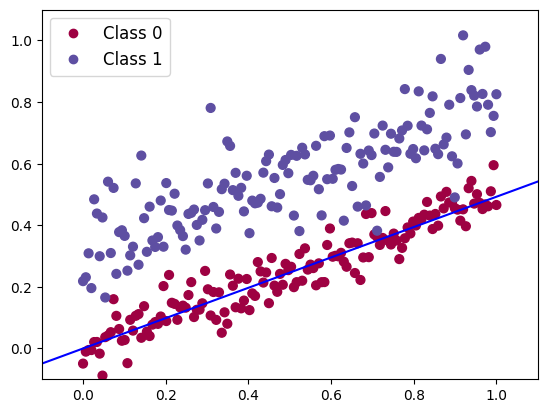

In [8]:
xx = np.linspace(min,max,2)
b = -1*np.mean(T)
b = 0
yy = xx*abs(eig_vecs[0,1]/eig_vecs[1,1])+b

fig = plt.figure()
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([min,max])
plt.ylim([min,max])
handles, labs = scatter.legend_elements() 
plt.plot(xx, yy,c='b')
plt.legend(handles,clabel,fontsize="large")
plt.show()